# Uncertainty Range Experiment
- Dataset : LoanPredict
- Model : RandomForestClassifier
- Reference Dataset : 2010년 (11497, 81)
- Inference Dataset : 2011년 ~ 2018년 (1,323,732, 1)

# 1 구글 드라이브 연결

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 함수 선언



In [26]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(x_inf_d):
    df_state = pd.DataFrame({"mean":np.mean(x_train,axis=0),"std":np.std(x_train,axis=0)})
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])

    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data():
    temp_X = []
    temp_Y = []
    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train)
        temp_X.append(random_sigma_add(x_train[sample_idx]))
        temp_Y.append(train_gt[sample_idx])
    return temp_X, temp_Y

In [6]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
def uncertainty_drift_checker(train, live, evals=100):
    if model_type == "Classification":
        d_value, p_vale = ks_2samp(entropy(train, axis=-1), entropy(live, axis=-1))

    elif model_type == "Regression":
        train_copy = np.concatenate([train for _ in range(evals)], axis=-1)
        test_copy = np.concatenate([live for _ in range(evals)], axis=-1)
        train_std = np.std(train_copy, axis=-1)
        live_std = np.std(test_copy, axis=-1)
        d_value, p_vale = ks_2samp(train_std, live_std)

    return d_value, p_vale

#3 데이터 전처리 및 모델학습

## 3-1 Loan Predict

In [ ]:
#@title
#-*- coding:utf-8 -*-
from sklearn.ensemble import RandomForestClassifier
import sklearn
import pandas as pd

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

df_accepted = pd.read_csv("drive/MyDrive/Colab Notebooks/mlops/iteration4/data/accepted_2007_to_2018Q4.csv")
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)

df_accepted.isnull().sum().sort_values(ascending=False).head(50)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)

df_accepted = df_accepted.dropna()

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

df_accepted = df_accepted.drop(columns='grade')
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])

df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


print('Set Dataset ============================================')
for year in range(2010,2019):
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values
    print(year, X[year].shape, Y[year].shape)


ML = {}
MODEL_TYPE = 'RF'  ## RF / DL

def build_model_rf(year,x,y,epochs=5):
    print(year, x.shape, y.shape)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(x,y)
    return model


def build_models():
    for year in range(2010,2019):
        print(str(year) + 'year training ======================================')
        epochs = 100 #(100 if year==2009 else 5)
        if MODEL_TYPE =='DL':
            pass
            #ML[year] = build_model_dl(year,X[year],Y[year],epochs=epochs)
        else:
            ML[year] = build_model_rf(year,X[year],Y[year],epochs=epochs)
        break

build_models()
# dfm = df_accepted.drop(columns=['issue_d'])

## 3-2 사용할 데이터

In [1]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

### ★ 수정부분

In [9]:
################################################################################################
#사용할 데이터 입력 할 곳
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)
################################################################################################

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [28]:
###########################################
train_size = 10000
test_size = 1000
live_size = 2000

x_train = X3.values[:train_size]
y_train_gt = y3[:train_size].reshape(-1,1)

x_test = X3[train_size:train_size+test_size].values
y_test_gt = y3[:train_size:train_size+test_size].reshape(-1,1)

x_live = X3[train_size+test_size:].values
y_live_gt = y3[train_size+test_size:].reshape(-1,1)

print(x_train.shape, x_test.shape, x_live.shape)
###########################################

(10000, 5) (1000, 5) (29000, 5)


In [22]:
### fit model ###
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=6).fit(x_train, y_train_gt)

#4 Experiment 실험

In [18]:
# 실험 모델 환경 설정
import sklearn.metrics as metrics
def acc_fn(y, predict):
    return metrics.accuracy_score(y, predict)*100


def f1_fn(y, predict):
    return metrics.f1_score(y, predict)


exp_model_param = {
    "exp_num":[100],#,5000,10000],
    "split_ratio": 10,
    "sigma":[0,3],
    "ramdom_sample_block":False,
    "metric":["acc", "f1"],
    "metric_threshold":[[5,15], [0.05, 0.15]],
    "metric_fn":[acc_fn, f1_fn]
    }

In [11]:
# 사용할 데이터 및 모델 설정
predict_fn = model.predict_proba
model_type = 'Classification'

y_train = predict_fn(x_train)
train_gt = y_train_gt

In [20]:
import warnings
warnings.filterwarnings(action='ignore')

for _ in enumerate(exp_model_param["exp_num"]):
    exp_X_list, exp_y_list = add_drirft_data()

result_d_value = []
result_score = []
for idx in range(len(exp_X_list)):
  exp_y_train = exp_y_list[idx]
  exp_predict = predict_fn(exp_X_list[idx])
  exp_predict_tmp = predict_fn(exp_X_list[idx])

  # 설정한 Metric을 기반으로 Score 계산
  exp_score = []
  for i, metric in enumerate(exp_model_param['metric']):
      if exp_predict_tmp.shape[1] != 1:
          exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
      exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))
  result_score.append(exp_score)

  # Uncertainty Value 계산
  d_value, _ = uncertainty_drift_checker(y_train, exp_predict)
  result_d_value.append(d_value)

## 4-1 LoanPredict

In [ ]:
#@title
temp_X = X[2011]
temp_Y = Y[2011]
for xx in X:
  if xx != 2010 and xx != 2011:
    temp_X = np.concatenate((temp_X, X[xx]), axis=0)
    temp_Y = np.concatenate((temp_Y, Y[xx]), axis=0)
print(temp_X.shape, temp_Y.shape)

In [ ]:
#@title
# 년도별 실험
# acc_list = []
# f1_list = []
# live_d_value = []
# fix_x = ML[2010].predict_proba(X[2010])
# for year in range(2011,2019):
#   live_x = X[year]
#   live_y = ML[2010].predict_proba(X[year])
#   live_gt = Y[year]

#   d_value, _ = uncertainty_drift_checker(fix_x, live_y)
#   acc_list.append(acc_fn(live_gt, np.argmax(live_y, axis=1)))
#   f1_list.append(f1_fn(live_gt, np.argmax(live_y, axis=1)))

#   live_d_value.append(d_value)

# live_score_list = [acc_list, f1_list]

In [ ]:
#@title
# 100 steps 실험
acc_list = []
f1_list = []
live_d_value = []
fix_x = ML[2010].predict_proba(X[2010])

data_len = int(temp_X.shape[0]/100)
for i in range(0, 97):
  start = data_len*i
  end = data_len*(i+1)
  if i % 10 == 0:
    print((i+1), start, end)

  live_x = temp_X[start:end]
  live_y = ML[2010].predict_proba(temp_X[start:end])
  live_gt = temp_Y[start:end]

  d_value, _ = uncertainty_drift_checker(fix_x, live_y)
  acc_list.append(acc_fn(live_gt, np.argmax(live_y, axis=1)))
  f1_list.append(f1_fn(live_gt, np.argmax(live_y, axis=1)))

  live_d_value.append(d_value)

live_score_list = [acc_list, f1_list]

## 4-2 사용할 데이터

In [32]:
# 실험
acc_list = []
f1_list = []
live_d_value = []
fix_x = model.predict_proba(x_train)

data_len = live_size
temp_X = x_live
temp_Y = y_live_gt

# data_len = int(temp_X.shape[0]/100)
# for i in range(0, 97):
for i in range(int(temp_X.shape[0]/live_size)):
  start = data_len*i
  end = data_len*(i+1)
  if i % 10 == 0:
    print((i+1), start, end)

  live_x = temp_X[start:end]
  live_y = model.predict_proba(temp_X[start:end])
  live_gt = temp_Y[start:end]

  d_value, _ = uncertainty_drift_checker(fix_x, live_y)
  acc_list.append(acc_fn(live_gt, np.argmax(live_y, axis=1)))
  f1_list.append(f1_fn(live_gt, np.argmax(live_y, axis=1)))

  live_d_value.append(d_value)

live_score_list = [acc_list, f1_list]

1 0 2000
11 20000 22000


#5 실험결과 출력

## 5-1 LoanPredict 결과

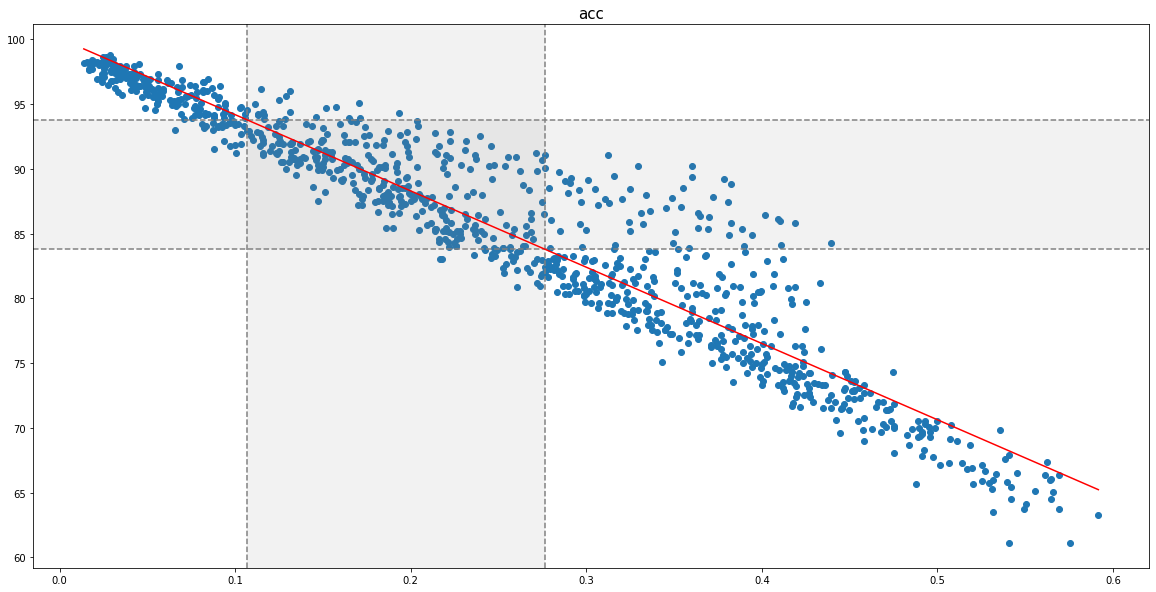

score : 93.78 ~ 83.78
d_val threshold : 0.11 ~ 0.28



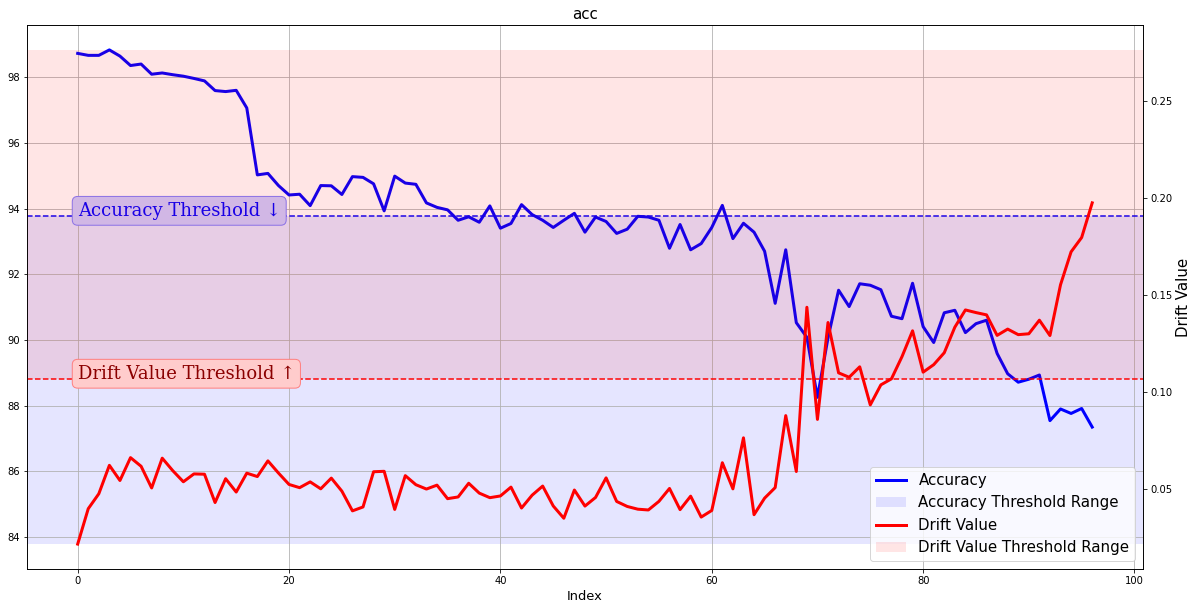

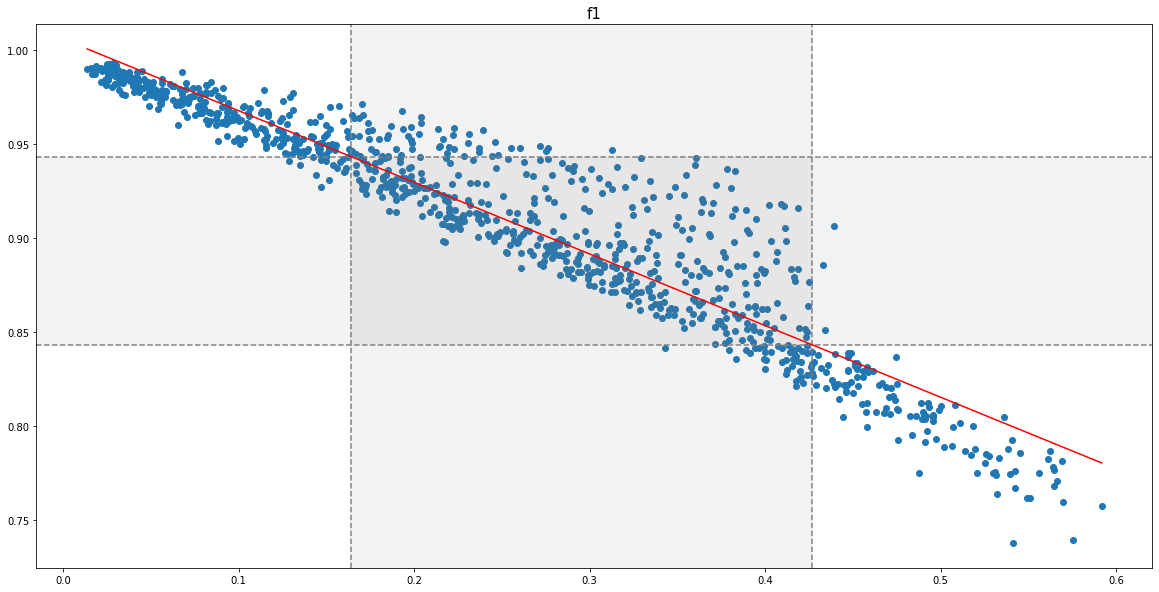

score : 0.94 ~ 0.84
d_val threshold : 0.16 ~ 0.43



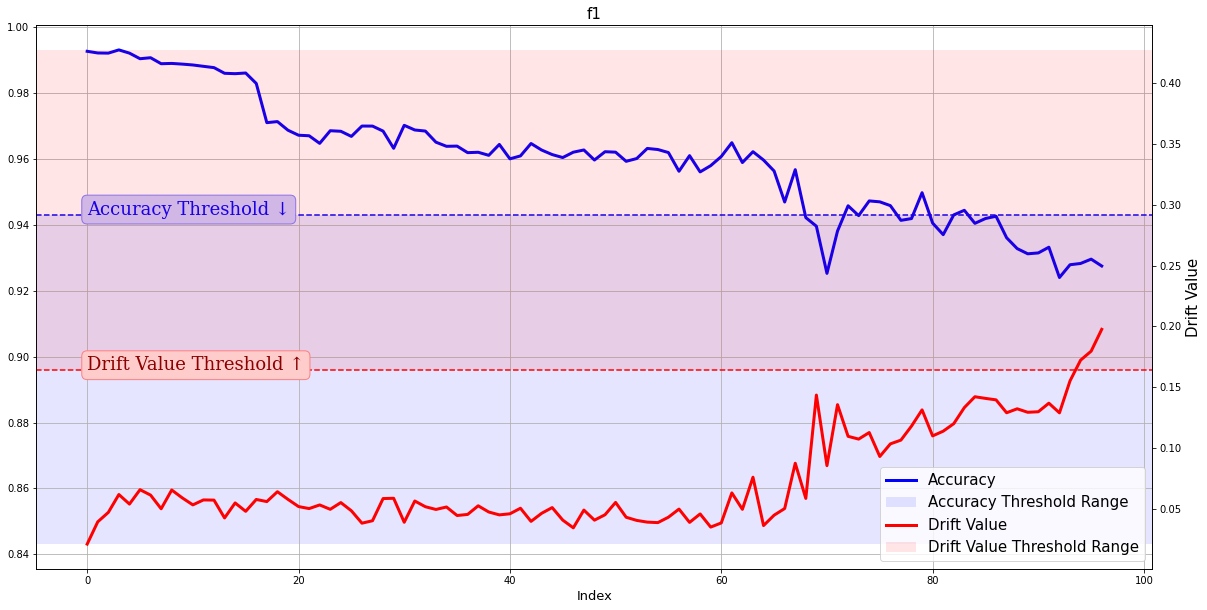

In [ ]:
#@title
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

font1 = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18}

font2 = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 18}

box1 = {'boxstyle': 'round',
        'ec': (1.0, 0.5, 0.5),
        'fc': (1.0, 0.8, 0.8)}

box2 = {'boxstyle': 'round',
        'ec': (0.5, 0.5, 1.0),
        'fc': (0.8, 0.8, 1.0)}


line_x = np.asarray(result_d_value)
for i in range(len(exp_model_param['metric'])):
    temp_result = [t[i] for t in result_score]
    line_y = np.asarray(temp_result)

    x_train, _, y_train, _ = train_test_split(line_x, line_y, test_size=0.3, random_state=50)
    lr = LinearRegression()
    lr.fit(x_train.reshape(-1,1), y_train) # train 데이터 학습
    f = lambda x: (lr.coef_ * x) + lr.intercept_
    f_i = lambda y: (y - lr.intercept_) / lr.coef_
    x = np.array([min(x_train), max(x_train)])

    x_dot = x
    y_dot = f(x)
    metric_threshold = []
    for temp_th in exp_model_param["metric_threshold"][i]:
      metric_threshold.append(max(temp_result) - temp_th)
    d_value_threhold = np.round(f_i(metric_threshold)[0], 3)

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    plt.axhspan(metric_threshold[0], metric_threshold[1], facecolor='gray', alpha = 0.1)
    plt.axvspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='gray', alpha = 0.1)
    plt.axhline(metric_threshold[0], color = "gray", linestyle="--")
    plt.axhline(metric_threshold[1], color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[0]), color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[1]), color = "gray", linestyle="--")
    plt.plot(x, f(x), color = "red")
    plt.scatter(result_d_value, temp_result)
    plt.show()
    print('score : %.2f ~ %.2f' % (metric_threshold[0], metric_threshold[1]))
    print('d_val threshold : %.2f ~ %.2f' % (f_i(metric_threshold[0]), f_i(metric_threshold[1])))
    print()

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    ax1.axhspan(metric_threshold[0], metric_threshold[1], facecolor='blue', alpha = 0.1, label = 'Accuracy Threshold Range')
    ax1.axhline(metric_threshold[0], color = "blue", linestyle="--")
    ax1.plot(live_score_list[i], color = 'blue', label='Accuracy', linewidth=3)
    ax1.text(0, metric_threshold[0], 'Accuracy Threshold ↓', fontdict=font2, bbox=box2)
    ax1.set_xlabel("Index",fontsize=13)
    ax1.grid()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Drift Value", fontsize=15)
    ax2.axhspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='red', alpha = 0.1, label = 'Drift Value Threshold Range')
    ax2.axhline(f_i(metric_threshold[0]), color = "red", linestyle="--")
    ax2.plot(live_d_value, color = 'red', label='Drift Value', linewidth=3)
    ax2.text(0, f_i(metric_threshold[0]), 'Drift Value Threshold ↑', fontdict=font1, bbox=box1)

    h,l = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h+h2,l+l2,loc=0 , prop={'size':15})
    plt.show()
    print()

## 5-2 사용할 데이터 결과

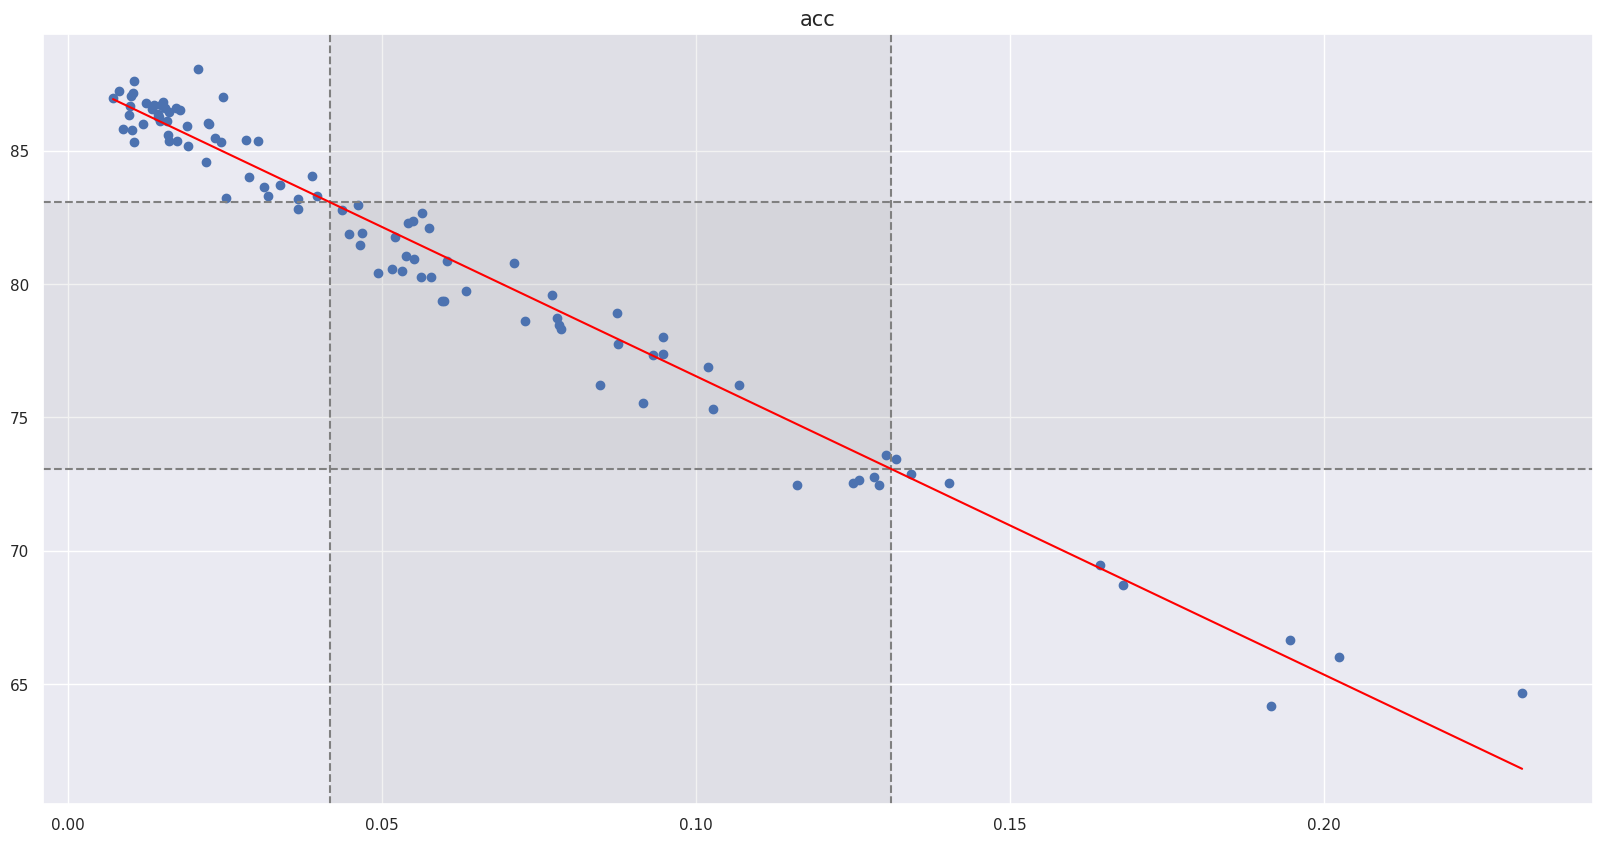

score : 83.08 ~ 73.08
d_val threshold : 0.04 ~ 0.13



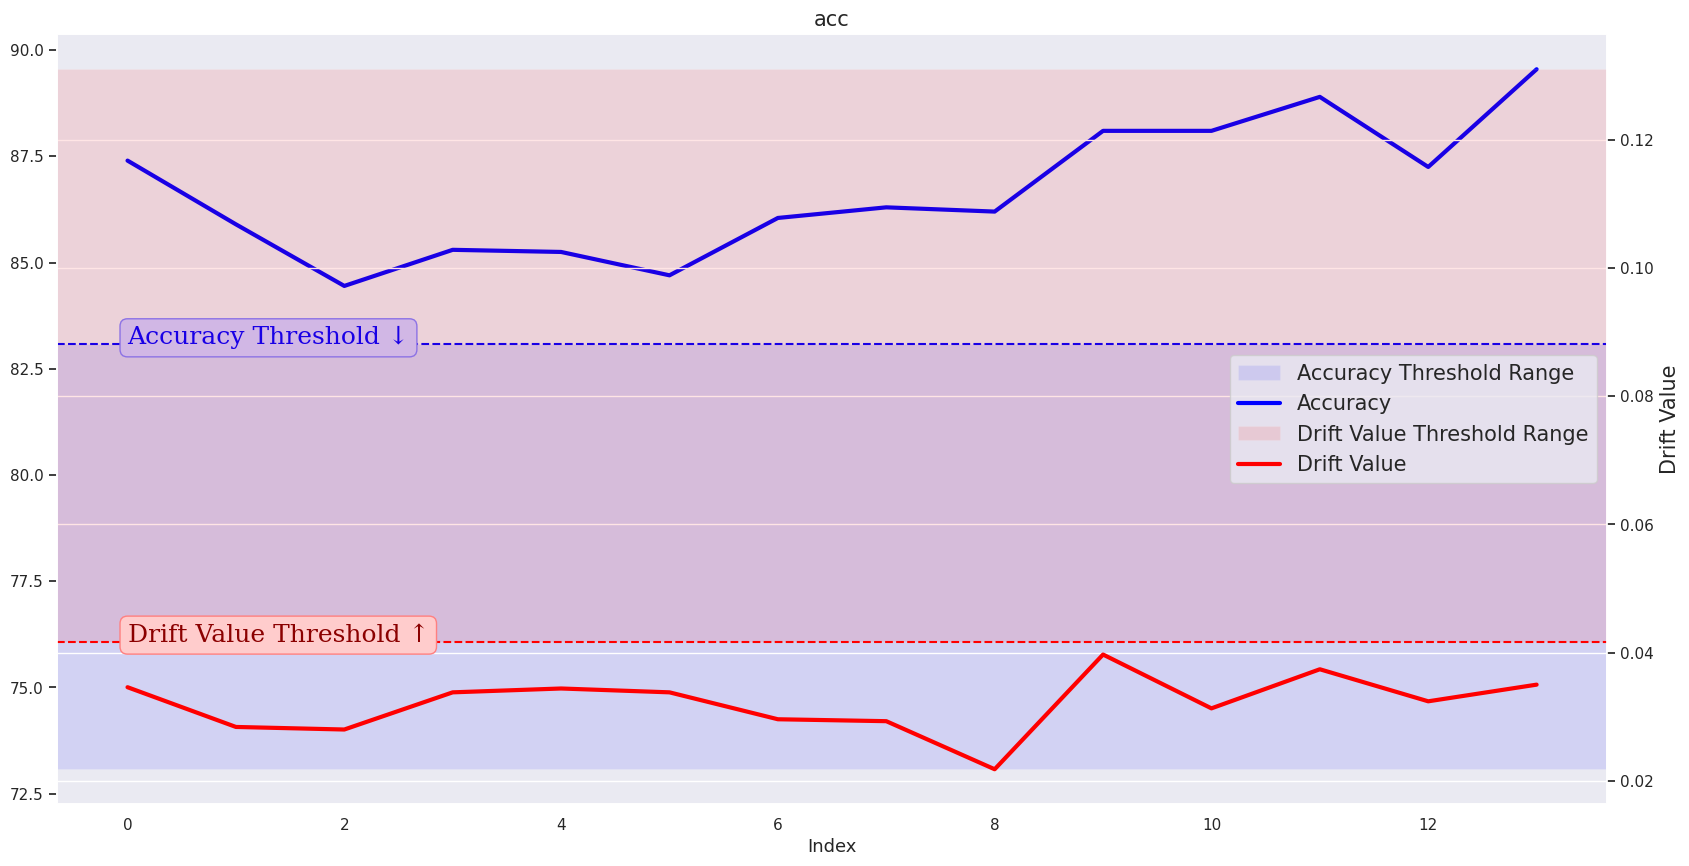

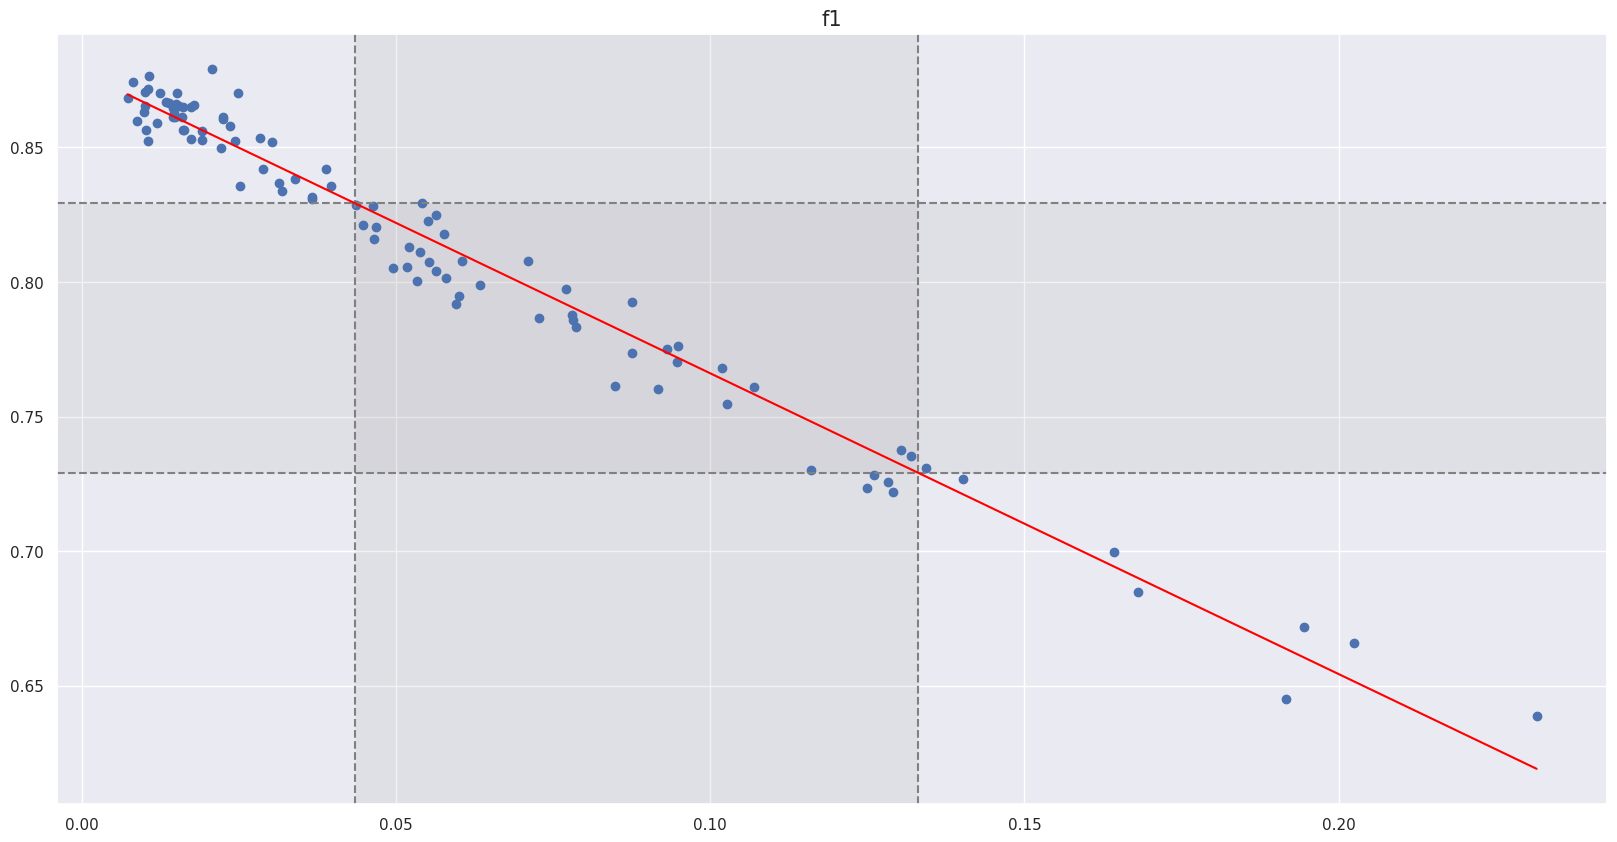

score : 0.83 ~ 0.73
d_val threshold : 0.04 ~ 0.13



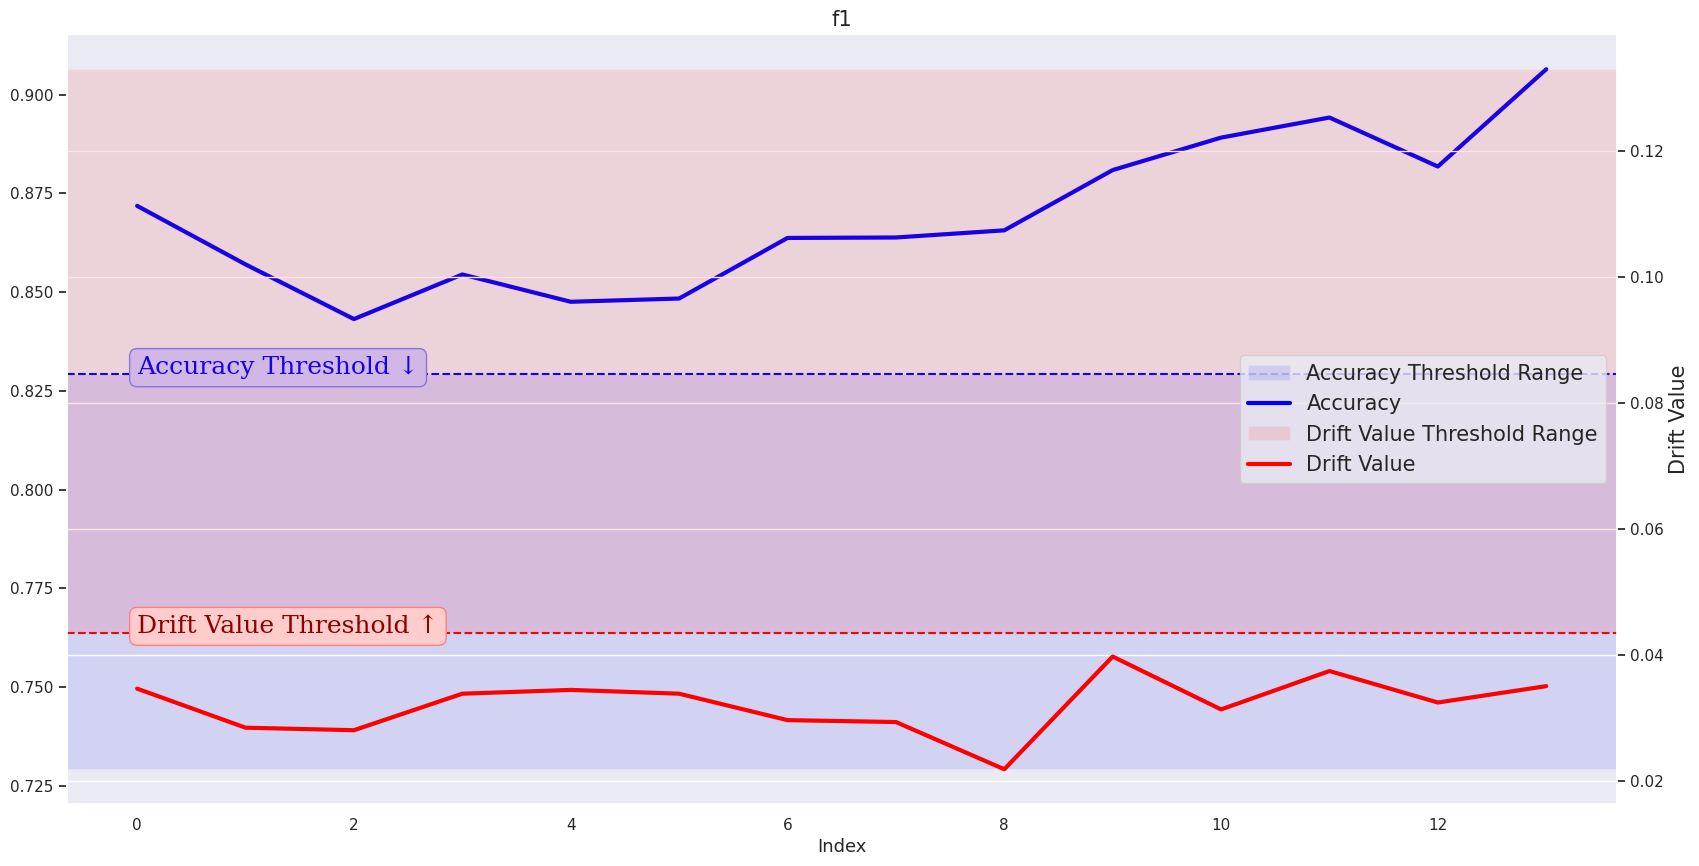

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

font1 = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18}

font2 = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 18}

box1 = {'boxstyle': 'round',
        'ec': (1.0, 0.5, 0.5),
        'fc': (1.0, 0.8, 0.8)}

box2 = {'boxstyle': 'round',
        'ec': (0.5, 0.5, 1.0),
        'fc': (0.8, 0.8, 1.0)}


line_x = np.asarray(result_d_value)
for i in range(len(exp_model_param['metric'])):
    temp_result = [t[i] for t in result_score]
    line_y = np.asarray(temp_result)

    x_train, _, y_train, _ = train_test_split(line_x, line_y, test_size=0.3, random_state=50)
    lr = LinearRegression()
    lr.fit(x_train.reshape(-1,1), y_train) # train 데이터 학습
    f = lambda x: (lr.coef_ * x) + lr.intercept_
    f_i = lambda y: (y - lr.intercept_) / lr.coef_
    x = np.array([min(x_train), max(x_train)])

    x_dot = x
    y_dot = f(x)
    metric_threshold = []
    for temp_th in exp_model_param["metric_threshold"][i]:
      metric_threshold.append(max(temp_result) - temp_th)
    d_value_threhold = np.round(f_i(metric_threshold)[0], 3)

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    plt.axhspan(metric_threshold[0], metric_threshold[1], facecolor='gray', alpha = 0.1)
    plt.axvspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='gray', alpha = 0.1)
    plt.axhline(metric_threshold[0], color = "gray", linestyle="--")
    plt.axhline(metric_threshold[1], color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[0]), color = "gray", linestyle="--")
    plt.axvline(f_i(metric_threshold[1]), color = "gray", linestyle="--")
    plt.plot(x, f(x), color = "red")
    plt.scatter(result_d_value, temp_result)
    plt.show()
    print('score : %.2f ~ %.2f' % (metric_threshold[0], metric_threshold[1]))
    print('d_val threshold : %.2f ~ %.2f' % (f_i(metric_threshold[0]), f_i(metric_threshold[1])))
    print()

    fig, ax1 = plt.subplots(figsize=(20,10))
    ax1.set_title(exp_model_param['metric'][i], fontsize=15)
    ax1.axhspan(metric_threshold[0], metric_threshold[1], facecolor='blue', alpha = 0.1, label = 'Accuracy Threshold Range')
    ax1.axhline(metric_threshold[0], color = "blue", linestyle="--")
    ax1.plot(live_score_list[i], color = 'blue', label='Accuracy', linewidth=3)
    ax1.text(0, metric_threshold[0], 'Accuracy Threshold ↓', fontdict=font2, bbox=box2)
    ax1.set_xlabel("Index",fontsize=13)
    ax1.grid()

    ax2 = ax1.twinx()
    ax2.set_ylabel("Drift Value", fontsize=15)
    ax2.axhspan(f_i(metric_threshold[0])[0], f_i(metric_threshold[1])[0], facecolor='red', alpha = 0.1, label = 'Drift Value Threshold Range')
    ax2.axhline(f_i(metric_threshold[0]), color = "red", linestyle="--")
    ax2.plot(live_d_value, color = 'red', label='Drift Value', linewidth=3)
    ax2.text(0, f_i(metric_threshold[0]), 'Drift Value Threshold ↑', fontdict=font1, bbox=box1)

    h,l = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    plt.legend(h+h2,l+l2,loc=0 , prop={'size':15})
    plt.show()
    print()